In [2]:
# Import libraries
import numpy as np
import tensorflow as tf
import os.path
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import GRU, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import metrics
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
os.chdir('C:\\Users\\anear\\OneDrive - National University of Ireland, Galway\\PhD\\Research Projects\\Ventilation Project')

Using TensorFlow backend.


In [19]:
# Load the data
_data = np.load('res/ML_data.npy', allow_pickle=True).tolist()
X_train_raw = _data['X_train']
y_train = _data['y_train']
X_val_raw = _data['X_val']
y_val = _data['y_val']
X_test_raw = _data['X_test']
y_test = _data['y_test']
print("Loaded!")

Loaded!


In [20]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 9065
No. of patients in train, val, test sets: 7252, 906, 907
No. of extubation failures in train, val, test sets: 2987, 383, 390
Proportion of extubation failures in train, val, test sets: 41.189%, 42.274%, 42.999%


In [22]:
# Check the shapes of the arrays
print("X_train_raw: {}".format(np.shape(X_train_raw)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val_raw: {}".format(np.shape(X_val_raw)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test_raw: {}".format(np.shape(X_test_raw)))
print("y_test: {}".format(np.shape(y_test)))

X_train_raw: (7252, 33, 24)
y_train: (7252,)
X_val_raw: (906, 33, 24)
y_val: (906,)
X_test_raw: (907, 33, 24)
y_test: (907,)


In [23]:
# Prepare training data for non-temporal models
m, n, T = np.shape(X_train_raw)
X_train_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_train_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_train_static[i,(j*4):(j*4+4)] = extracted_features
        
# Prepare test data for non-temporal models
m, n, T = np.shape(X_test_raw)
X_test_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_test_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_test_static[i,(j*4):(j*4+4)] = extracted_features
        
# Check the shapes of the new arrays
print("X_train_static: {}".format(np.shape(X_train_static)))
print("X_test_static: {}".format(np.shape(X_test_static)))

X_train_static: (7252, 132)
X_test_static: (907, 132)


In [24]:
# Scale the training data using a z-transform, and apply that scaler to the test data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_static)
X_test_scaled = scaler.transform(X_test_static)
print(np.shape(X_train_scaled))

(7252, 132)


In [25]:
# Create logistic regression classifer object
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = "liblinear")

# Train logistic regression classifer
logisticRegr.fit(X_train_scaled, y_train)

# Predict the response for test dataset
y_pred = logisticRegr.predict_proba(X_test_scaled)[:,1]

In [26]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred)

In [29]:
# Calculate the AUROC for the test set
from sklearn.metrics import auc
auc_lr = auc(fpr_lr, tpr_lr)

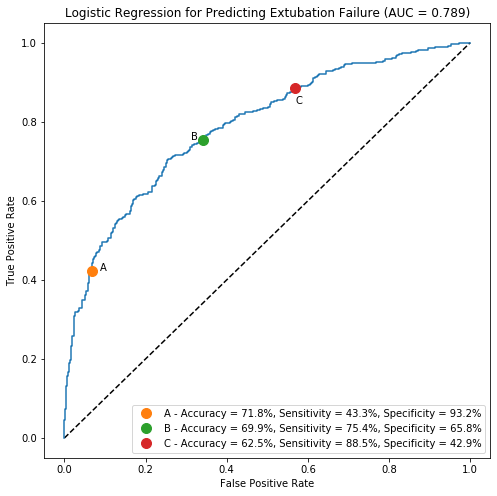

In [30]:
# Choose the three thresholds
thresh_A, thresh_B, thresh_C = 0.6, 0.35, 0.25
A = np.where(thresholds==thresholds[thresholds>=thresh_A][-1])
B = np.where(thresholds==thresholds[thresholds>=thresh_B][-1])
C = np.where(thresholds==thresholds[thresholds>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_test, y_pred[:]>thresh_A)
[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_test, y_pred[:]>thresh_B)
[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_test, y_pred[:]>thresh_C)

# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.plot(fpr[A], tpr[A],'.', markersize=20, label='A - Accuracy = {:.1f}%, Sensitivity = {:.1f}%, Specificity = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A)))
plt.annotate('A', (fpr[A]+0.02, tpr[A]))
plt.plot(fpr[B], tpr[B],'.', markersize=20, label='B - Accuracy = {:.1f}%, Sensitivity = {:.1f}%, Specificity = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B)))
plt.annotate('B', (fpr[B]-0.03, tpr[B]))
plt.plot(fpr[C], tpr[C],'.', markersize=20, label='C - Accuracy = {:.1f}%, Sensitivity = {:.1f}%, Specificity = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C)))
plt.annotate('C', (fpr[C], tpr[C]-0.04))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression for Predicting Extubation Failure (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.savefig('lr.png', bbox_inches='tight')
plt.show()

In [31]:
# Write a function that plots nice confusion matrices
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm[0][0] = round(cm[0][0],2)
        cm[0][1] = round(cm[0][1],2)
        cm[1][0] = round(cm[1][0],2)
        cm[1][1] = round(cm[1][1],2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

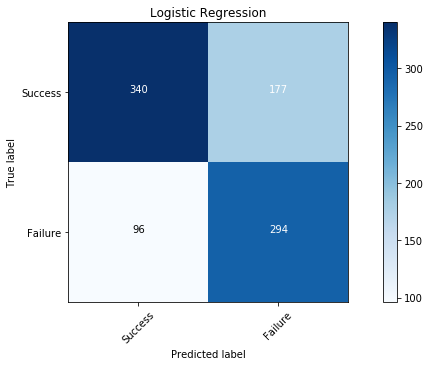

In [32]:
# Calculate the confusion matrix
decision_threshold = thresh_B
cm = confusion_matrix(y_test, y_pred[:]>decision_threshold)
plot_confusion_matrix(cm, ['Success', 'Failure'], normalize=False, title='Logistic Regression')